In [1]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as mpatches

%matplotlib notebook

In [2]:
def addgeo(shapef,ax,edgecolor='black',facecolor='white',alpha=0.5):
    shape = list(shpreader.Reader(shapef).geometries())
    record = list(shpreader.Reader(shapef).records())
    ax.add_geometries(shape, ccrs.epsg(26910),
                  edgecolor=edgecolor, facecolor=facecolor, alpha=alpha)
    return shape, record

<IPython.core.display.Javascript object>


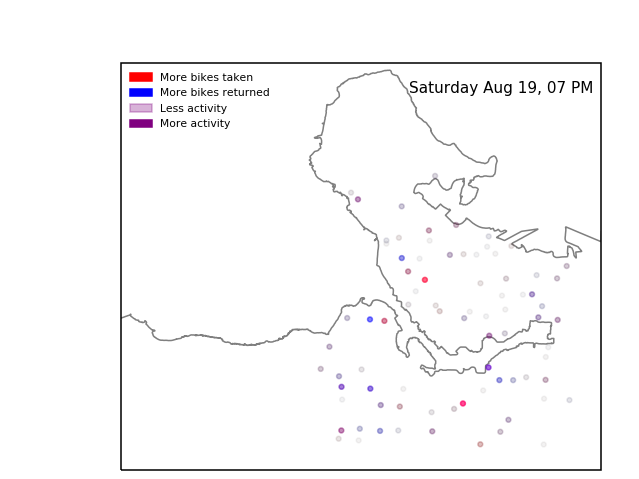

In [3]:
f, ax = plt.subplots()
ax = plt.axes(projection=ccrs.epsg(26910))

left = 486644
right = 493313
bottom = 5455579
top = 5462500

ax.set_extent([left-1500,right,bottom,top ], ccrs.epsg(26910))

red_patch = mpatches.Patch(color='red', label='More bikes taken')
blue_patch = mpatches.Patch(color='blue', label='More bikes returned')
#purple_patch = mpatches.Patch(color='purple', label='Even # taken and returned')
pale_patch = mpatches.Patch(color='purple', alpha=0.3, label='Less activity')
bright_patch = mpatches.Patch(color='purple', alpha=1, label='More activity')


plt.legend(handles=[red_patch,blue_patch,pale_patch,bright_patch],loc=2,prop={'size':7},frameon=False)

In [5]:
coast,coastr = addgeo('/Users/msj/Dropbox/urban/maps/shoreline2002.shp',ax)

In [6]:
#Load mobi daily data
thedate = '2017-08-19'
thdf = pd.read_pickle('taken_hourly_df.p')
thdfdate = thdf.loc[thedate:]

rhdf = pd.read_pickle('returned_hourly_df.p')
rhdfdate = rhdf.loc[thedate:]

ddf = pd.read_pickle('daily_mobi_dataframe.p')
ddf = ddf[['coordinates','name']].drop_duplicates()
ddf = pd.concat([ddf['coordinates'].str.split(',', expand=True),ddf['name']],axis=1)
ddf.columns = ['lat','long','name']
ddf.lat = ddf.lat[ddf.lat != ''].astype('float')
ddf.long = ddf.long[ddf.long != ''].astype('float')

In [7]:
nstations = len(thdfdate.columns)
alphas = np.linspace(0, 1,nstations)
rgba_colors = np.zeros((nstations,4))
# for red the first column needs to be one
rgba_colors[:,0] = 1.0
# the fourth column needs to be your alphas
rgba_colors[:, 3] = 0

In [8]:
stations = ax.scatter(ddf['long'],ddf['lat'],},color=rgba_colors,s=10,zorder=100)

In [9]:
datetext = ax.text(left+3400,top-500,'',transform=ccrs.epsg(26910))

In [10]:
def run(i):
    ax.text
    for j,station in enumerate(thdf.columns):
        bikes_taken = np.nan_to_num(thdfdate.iloc[i,j]) 
        bikes_returned = np.nan_to_num(rhdfdate.iloc[i,j])
        bike_activity = bikes_taken+bikes_returned
        bike_difference = bikes_taken-bikes_returned
        
        rgba_colors[j,2] = min([1,bikes_taken/10])
        rgba_colors[j,0] = min([1,bikes_returned/10])
        rgba_colors[j,3] = min([1,bike_activity/20])
        
    stations.set_color(rgba_colors)
    datetext.set_text("{}".format(thdfdate.index[i].strftime('%A %b %d, %I %p')))
    return stations,

In [11]:
ani = animation.FuncAnimation(f, run,frames=24, interval=1200)

In [ ]:
run(0)

In [14]:
ani.save('station_animation.gif',
         writer='imagemagick',
         fps=1,
         savefig_kwargs={'facecolor':f.get_facecolor()}
         )

In [ ]:
rgba_colors.max()

# Some simpler images of station usage

In [ ]:
def make_mobi_map(df,ddf,description):

    from mpl_toolkits.axes_grid1.inset_locator import inset_axes

    f, ax = plt.subplots()
    ax = plt.axes(projection=ccrs.epsg(26910))

    left = 486644
    right = 493313
    bottom = 5455579
    top = 5462500


    ndf = pd.merge(ddf,df.sum(0).reset_index(),left_on='name',right_on='index',how='inner')
    ndf.columns=['lat','long','name','index','activity']

    ax.set_extent([left-1500,right,bottom,top ], ccrs.epsg(26910))

    scat = ax.scatter(ddf['long'],
                             ddf['lat'],transform=ccrs.PlateCarree(),
                             s=10,
                             c=ndf['activity'],
                             cmap = 'cool',
                             zorder=100)

    cbaxes = inset_axes(ax, width="30%", height="3%", loc=2) 
    cbar = plt.colorbar(scat,cax=cbaxes,orientation='horizontal')
    cbar.ax.set_xticklabels(cbar.ax.get_xticklabels(),rotation=60)


    #f.colorbar(taken_total)
    ax.text(left-1000,top-3000,description,transform=ccrs.epsg(26910))

    coast,coastr = addgeo('/Users/msj/Dropbox/mobi/maps/shoreline2002.shp',ax)
    _ = addgeo('/Users/msj/Dropbox/mobi/maps/bikeways.shp',ax,'green',alpha=0.2)
    f.savefig('{}.png'.format(description.replace(' ','-').replace('\n','-')))
    return f, ax

In [ ]:
f,ax = make_mobi_map(rhdf,ddf,'Total Bikes Returned\nJune-Oct 2017')

In [ ]:
f,ax = make_mobi_map(thdf,ddf,'Total Bikes Taken\nJune-Oct 2017')

In [ ]:
ahdf = pd.read_pickle('activity_hourly_df.p')

In [ ]:
f,ax = make_mobi_map(ahdf,ddf,'Total Station Activity\nJune-Oct 2017')

In [ ]:
f,ax = make_mobi_map(rhdf['2017-08-23'],ddf,'Total Station Activity\nAugust 2017')

In [ ]:
f,ax = make_mobi_map(rhdf['2017-08-06'],ddf,'Total Station Activity\nAugust 2017')

# Separate stations with PCA

In [ ]:
thdf.head()

In [ ]:
pivoted = thdf.T.fillna(0)

In [ ]:
pivoted2 = rhdf.T.fillna(0)

In [ ]:
pivoted = pd.merge(pivoted,pivoted2,left_index=True,right_index=True)

In [ ]:
pivoted.head()

In [ ]:
X = pivoted.values
print(X.sum())
X.shape

In [ ]:
from sklearn.decomposition import PCA
Xpca = PCA(0.9).fit_transform(X)
Xpca.shape

In [ ]:
total_trips = X.sum(1)
f,ax = plt.subplots()
scat = ax.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips, cmap='cool',picker=0.5)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
f.colorbar(scat,label='total trips');
f.savefig('PCA_stations.png')

In [ ]:
total_trips = X.sum(1)
f,ax = plt.subplots()
scat = ax.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips, cmap='cool',picker=0.5)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
f.colorbar(scat,label='total trips');


for station,x,y in zip(pivoted.index.values,Xpca[:,0],Xpca[:,1]):
    if  y>50:
        ax.annotate('',(x,y),xytext=(-10,-20),textcoords='offset points',arrowprops=dict(facecolor='black', headwidth=10, alpha=0.4, width=1))
        print(station)
f.savefig('PCA_stations_labeled1.png')

In [ ]:
total_trips = X.sum(1)
f,ax = plt.subplots()
scat = ax.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips, cmap='cool',picker=0.5)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
f.colorbar(scat,label='total trips');


for station,x,y in zip(pivoted.index.values,Xpca[:,0],Xpca[:,1]):
    if  x>150 and 0<y<50:
        ax.annotate('',(x,y),xytext=(-10,-20),textcoords='offset points',arrowprops=dict(facecolor='black', headwidth=10, alpha=0.4, width=1))
        print(station)
f.savefig('PCA_stations_labeled2.png')

In [ ]:
total_trips = X.sum(1)
f,ax = plt.subplots()
scat = ax.scatter(Xpca[:, 0], Xpca[:, 1], c=total_trips, cmap='cool',picker=0.5)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
f.colorbar(scat,label='total trips');


for station,x,y in zip(pivoted.index.values,Xpca[:,0],Xpca[:,1]):
    if  x>100 and y<0:
        ax.annotate('',(x,y),xytext=(-10,-20),textcoords='offset points',arrowprops=dict(facecolor='black', headwidth=10, alpha=0.4, width=1))
        print(station)
f.savefig('PCA_stations_labeled3.png')